In [98]:
import pandas as pd
import numpy as np

import hist
import pickle

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

import HH4b.utils as utils 
import HH4b.plotting as plotting
import postprocessing

import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [8]:
#Load your dataset
samples = {
    "qcd": [
        "QCD_HT-200to400",
        # "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
        "QCD_HT-1000to1200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
    ],
    "ttbar": [
        "TTto4Q",
        "TTtoLNu2Q",
    ],  
    "hh4b": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
    ],
    "vbfhh4b": [
        "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
    ],
    "vhbb": [
        "ZH_Hto2B_Zto2Q_M-125",
        "WplusH_Hto2B_Wto2Q_M-125",
        "WminusH_Hto2B_Wto2Q_M-125"
    ]
}

MAIN_DIR = "../../../"
year = "2022EE"
dir_name = "24Jan18_v12"
# path_to_dir = f"/eos/uscms/store/user/dprim7/bbbb/skimmer/{dir_name}/"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/{dir_name}/"
dirs = {path_to_dir: samples}

# columns to load                                                                                                                                                                                                                                     
load_columns = [
    ("weight", 1),
    ("MET_pt", 1),
    ("nFatJets", 1),
    ("ak8FatJetPt", 2),
    ("ak8FatJetEta", 2),
    ("ak8FatJetPhi", 2),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
	("ak8FatJetPNetXbb", 2),    
    ("ak8FatJetTau3OverTau2", 2),                                                                                                                                                                                                              
]
# reformat into ("column name", "idx") format for reading multiindex columns                                                                                                                                                                          
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetPt', '1')", ">=", 300),
        ("('ak8FatJetMsd', '0')", "<=", 250),
        ("('ak8FatJetMsd', '1')", "<=", 250),
        ("('ak8FatJetMsd', '0')", ">=", 50),    
        ("('ak8FatJetMsd', '1')", ">=", 50),
        ("('MET_pt', '0')", "<=", 1000),            
    ],
    #[
    #    ("('ak8FatJetPt', '0')", ">=", 300),
    #    ("('ak8FatJetPt', '1')", ">=", 300),
    #    ("('ak8FatJetPNetMass', '0')", "<=", 250),
    #    ("('ak8FatJetPNetMass', '1')", "<=", 250),
    #    ("('ak8FatJetPNetMass', '0')", ">=", 50),    
    #    ("('ak8FatJetPNetMass', '1')", ">=", 50),
    #    ("('MET_pt', '0')", "<=", 1000),            
    #],
]

events_dict = {}
for input_dir, samples in dirs.items():
   
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns_mc=columns),
    }


print("Keys:")
print(events_dict.keys())
for key in events_dict:
    print(key, len(events_dict[key]))

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(keys_loaded)


Loading QCD_HT-2000
Loading QCD_HT-800to1000
Loading QCD_HT-600to800
Loading QCD_HT-1500to2000
Loading QCD_HT-200to400
Loading QCD_HT-1000to1200
Loading QCD_HT-1200to1500
Loading TTtoLNu2Q
Loading TTto4Q
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loading VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8
Loading WplusH_Hto2B_Wto2Q_M-125
Loading WminusH_Hto2B_Wto2Q_M-125
Loading ZH_Hto2B_Zto2Q_M-125
Keys:
dict_keys(['qcd', 'ttbar', 'hh4b', 'vbfhh4b', 'vhbb'])
qcd 662466
ttbar 357082
hh4b 52637
vbfhh4b 9305
vhbb 33135
[('weight', 0), ('MET_pt', 0), ('nFatJets', 0), ('ak8FatJetPt', 0), ('ak8FatJetPt', 1), ('ak8FatJetEta', 0), ('ak8FatJetEta', 1), ('ak8FatJetPhi', 0), ('ak8FatJetPhi', 1), ('ak8FatJetMsd', 0), ('ak8FatJetMsd', 1), ('ak8FatJetPNetMass', 0), ('ak8FatJetPNetMass', 1), ('ak8FatJetPNetXbb', 0), ('ak8FatJetPNetXbb', 1), ('ak8FatJetTau3OverTau2', 0), ('ak8FatJetTau3OverTau2', 1), ('weight_nonorm', '')]


The h candidates are the first two fatjets (ordered by Xbb):

In [83]:
# this mask assumes that only two jets are loaded and the 3rd jet is not relevant
# TODO: sort jets in skimmer
bb_masks = postprocessing.bb_assignment(events_dict)

events_dict_bdt = {}

for key, events in events_dict.items():
    # all the features that start with "bb" will apply this mask
    bb_mask = bb_masks[key]

    # for feat in ["Pt","Eta","Phi","PNetMass"]:
    #    for i in range(2):
    #         events[f"bb{i}FatJet{feat}"] = utils.get_feat(events, f"bb{i}FatJet{feat}", bb_masks[key])

    # take PNetMass to form the 4-vector
    # this function will take the bb_mask into account automatically
    #h1 = utils.make_vector(events, "bb0FatJet", bb_mask=bb_mask, mstring="PNetMass")
    #h2 = utils.make_vector(events, "bb1FatJet", bb_mask=bb_mask, mstring="PNetMass")

    # take mSD to form the 4-vector
    h1 = utils.make_vector(events, "bb0FatJet", bb_mask=bb_mask, mstring="Msd")
    h2 = utils.make_vector(events, "bb1FatJet", bb_mask=bb_mask, mstring="Msd")

    # dihiggs candidate object
    hh = h1 + h2

    # bdt variables
    df = pd.DataFrame({
        # dihiggs system
        "HHlogPt": np.log(hh.pt),
        'HHeta' : hh.eta,
        'HHmass' : hh.mass,
        # met in the event
        'MET' :  events.MET_pt[0],  
        # fatjet tau32
        'H1T32' : utils.get_feat(events, "bb0FatJetTau3OverTau2", bb_mask),
        'H2T32' : utils.get_feat(events, "bb1FatJetTau3OverTau2", bb_mask),
        # fatjet mass
        'H1Msd' : utils.get_feat(events, "bb0FatJetMsd", bb_mask),
        'H1PNetMass' : utils.get_feat(events, "bb0FatJetPNetMass", bb_mask),
        'H2Msd' : utils.get_feat(events, "bb1FatJetMsd", bb_mask),
        'H2PNetMass' : utils.get_feat(events, "bb0FatJetPNetMass", bb_mask),
        # fatjet kinematics
        'H1logPt' : np.log(h1.pt),
        'H2logPt' : np.log(h2.pt),
        'H1eta' : h1.eta,
        'H2eta' : h2.eta,
        'H1_dRH2': h1.deltaR(h2),
        'H1_dPhiH2': h1.deltaphi(h2),
        # xbb
        'H1Xbb': utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask),
        'H2Xbb': utils.get_feat(events, "bb1FatJetPNetXbb", bb_mask),
        # ratios
        'H1Pt_HHmass' : h1.pt/hh.mass,
        'H2Pt_HHmass' : h2.pt/hh.mass,
        'H1Pt/H2Pt' : h1.pt/h2.pt,
        # --- additional features to consider? -----
        # number of fatjets in the event
        # add VBF jet information?
        # cos(theta_star)
    })

    df.replace(np.inf, 10000, inplace=True)
    df.replace(-np.inf, 10000, inplace=True)

    events_dict_bdt[key] = df

variables_not_in_bdt = [
    # not use PnetMass until we debug it
    "H1PNetMass", 
    # not use H2 mass to avoid correlations
    "H2Msd", "H2PNetMass",
    # not use H1Xbb so that we can further cut on it
    "H1Xbb",
]


Now we plot the BDT variables

In [85]:
num_rows = len(events_dict_bdt["hh4b"].columns)

fig, axes = plt.subplots(num_rows, 1, figsize=(12,4*num_rows))
for i, col in enumerate(events_dict_bdt["hh4b"].columns):
    for key,events in events_dict_bdt.items():
        # axes[i].hist(events[col].dropna(), bins=50, alpha=0.3, density=True, label=key)
        axes[i].hist(events[col].dropna(), bins=50, alpha=0.3, label=key)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Events')
    axes[i].legend(fontsize=10)
    axes[i].set_yscale('log')
plt.tight_layout()
plt.show()

In [86]:
events = pd.concat([
        events_dict_bdt["hh4b"], 
        events_dict_bdt["qcd"], 
        events_dict_bdt["ttbar"]
    ], 
    keys=['hh4b', 'qcd', 'ttbar']
)
events['target'] = 0  # Default to 0 (background)
events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)

# Define target
target = events['target']

# load features into pandas df
features = events
features.drop(columns=["target"], inplace=True)
features.drop(columns=variables_not_in_bdt, inplace=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_72413/3575550030.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc['hh4b', 'target'] = 1  # Set to 1 for 'hh4b' samples (signal)


In [87]:
features.columns

Index(['HHlogPt', 'HHeta', 'HHmass', 'MET', 'H1T32', 'H2T32', 'H1Msd',
       'H1logPt', 'H2logPt', 'H1eta', 'H2eta', 'H1_dRH2', 'H1_dPhiH2', 'H2Xbb',
       'H1Pt_HHmass', 'H2Pt_HHmass', 'H1Pt/H2Pt'],
      dtype='object')

In [88]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators= 196,
    max_depth= 17,
    learning_rate=0.1,
    subsample=0.5,
    random_state=42
)

# Train the model 
bdt_model.fit(X_train, y_train)

# Save the model
model_file = 'boostedBDT.json'
bdt_model.save_model(model_file)

In [89]:
#determine importance of the features
importances = bdt_model.feature_importances_

feature_names = events.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")


H2Xbb: 0.224
H1Msd: 0.111
HHmass: 0.066
H1Pt_HHmass: 0.058
H2T32: 0.048
H2logPt: 0.046
H1T32: 0.043
H1eta: 0.042
H2Pt_HHmass: 0.041
H1_dRH2: 0.041
H1Pt/H2Pt: 0.040
HHlogPt: 0.040
H2eta: 0.040
HHeta: 0.040
MET: 0.040
H1logPt: 0.040
H1_dPhiH2: 0.038


In [90]:
# Make predictions
predictions = bdt_model.predict(X_test)
probabilities = bdt_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

In [91]:
# plot scores
y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

In [92]:
y_scores

array([0.00015486, 0.00204376, 0.00016605, ..., 0.00077361, 0.00410194,
       0.00025759], dtype=float32)

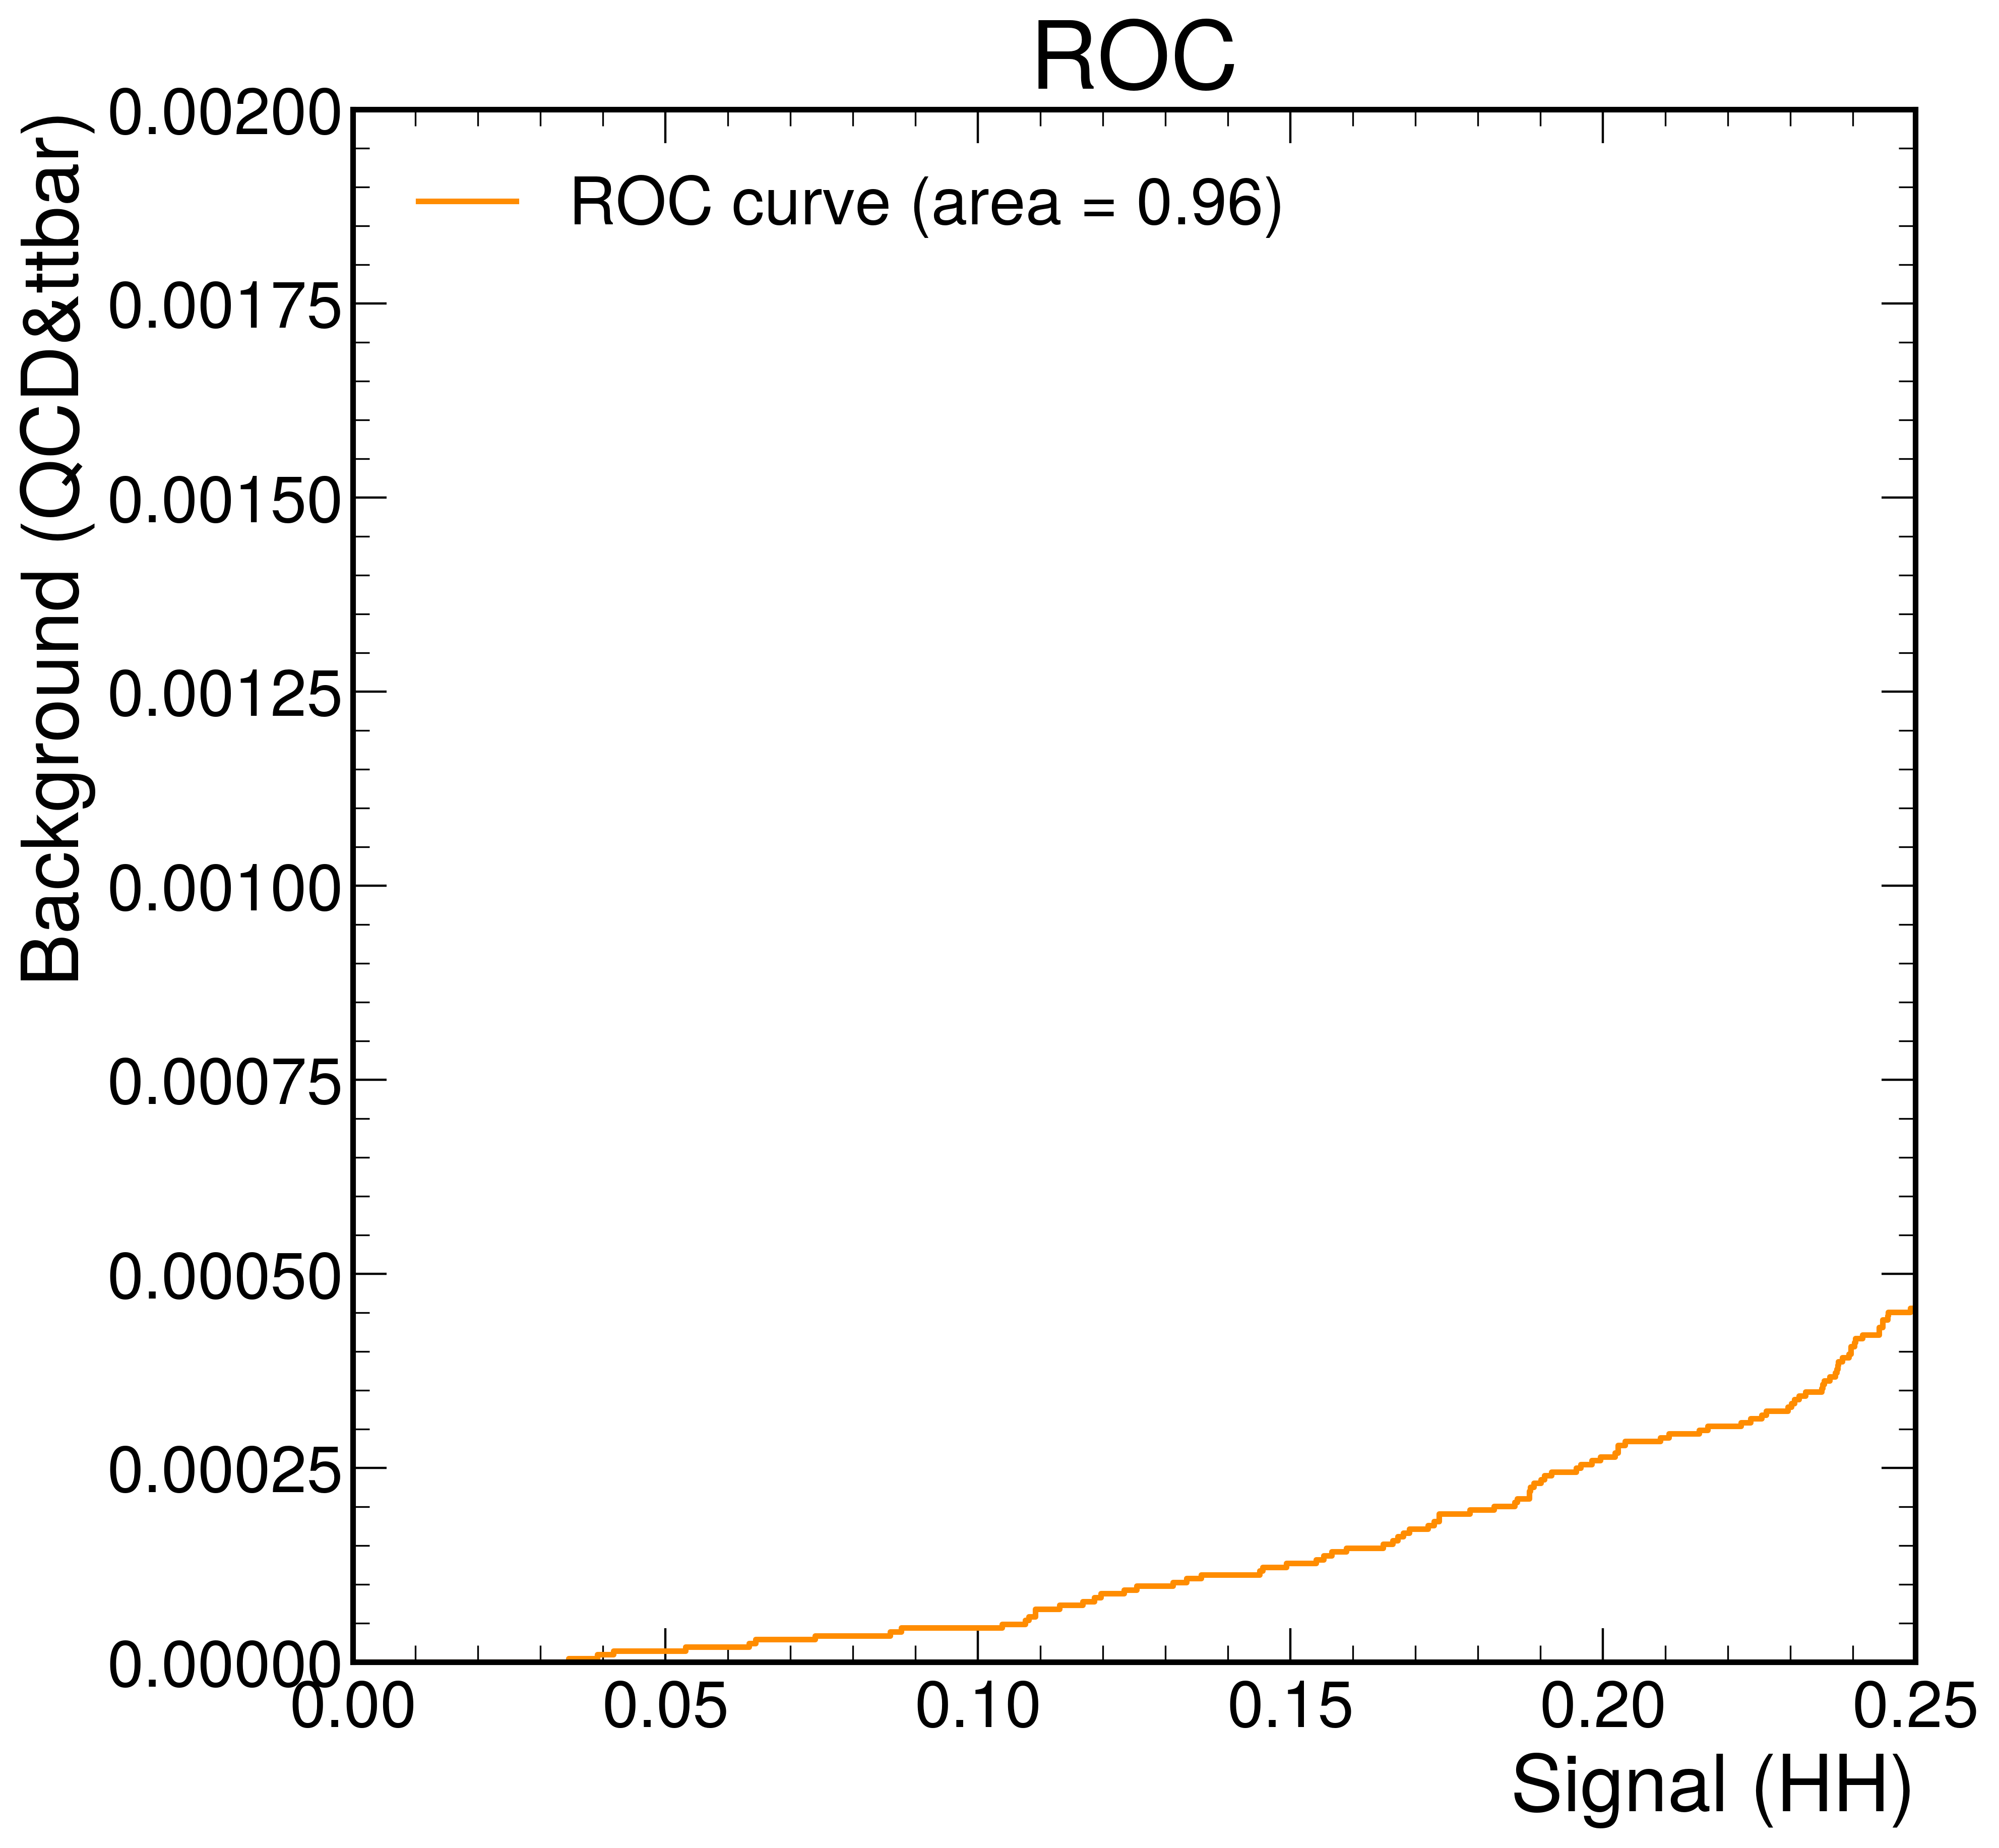

In [117]:
# Plottting ROC curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('Signal (HH)')
plt.ylabel('Background (QCD&ttbar)')
plt.title('ROC')
plt.legend(loc="upper left")
# plt.yscale('log')
plt.ylim(0, 0.002)
plt.xlim(0, 0.25)
plt.savefig(f'{MAIN_DIR}/../data/boosted-bdt/ROC_BDT.png')
plt.show()

In [94]:
hh4b_scores = bdt_model.predict_proba(X_test.loc['hh4b'])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc['qcd'])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc['ttbar'])[:, 1]

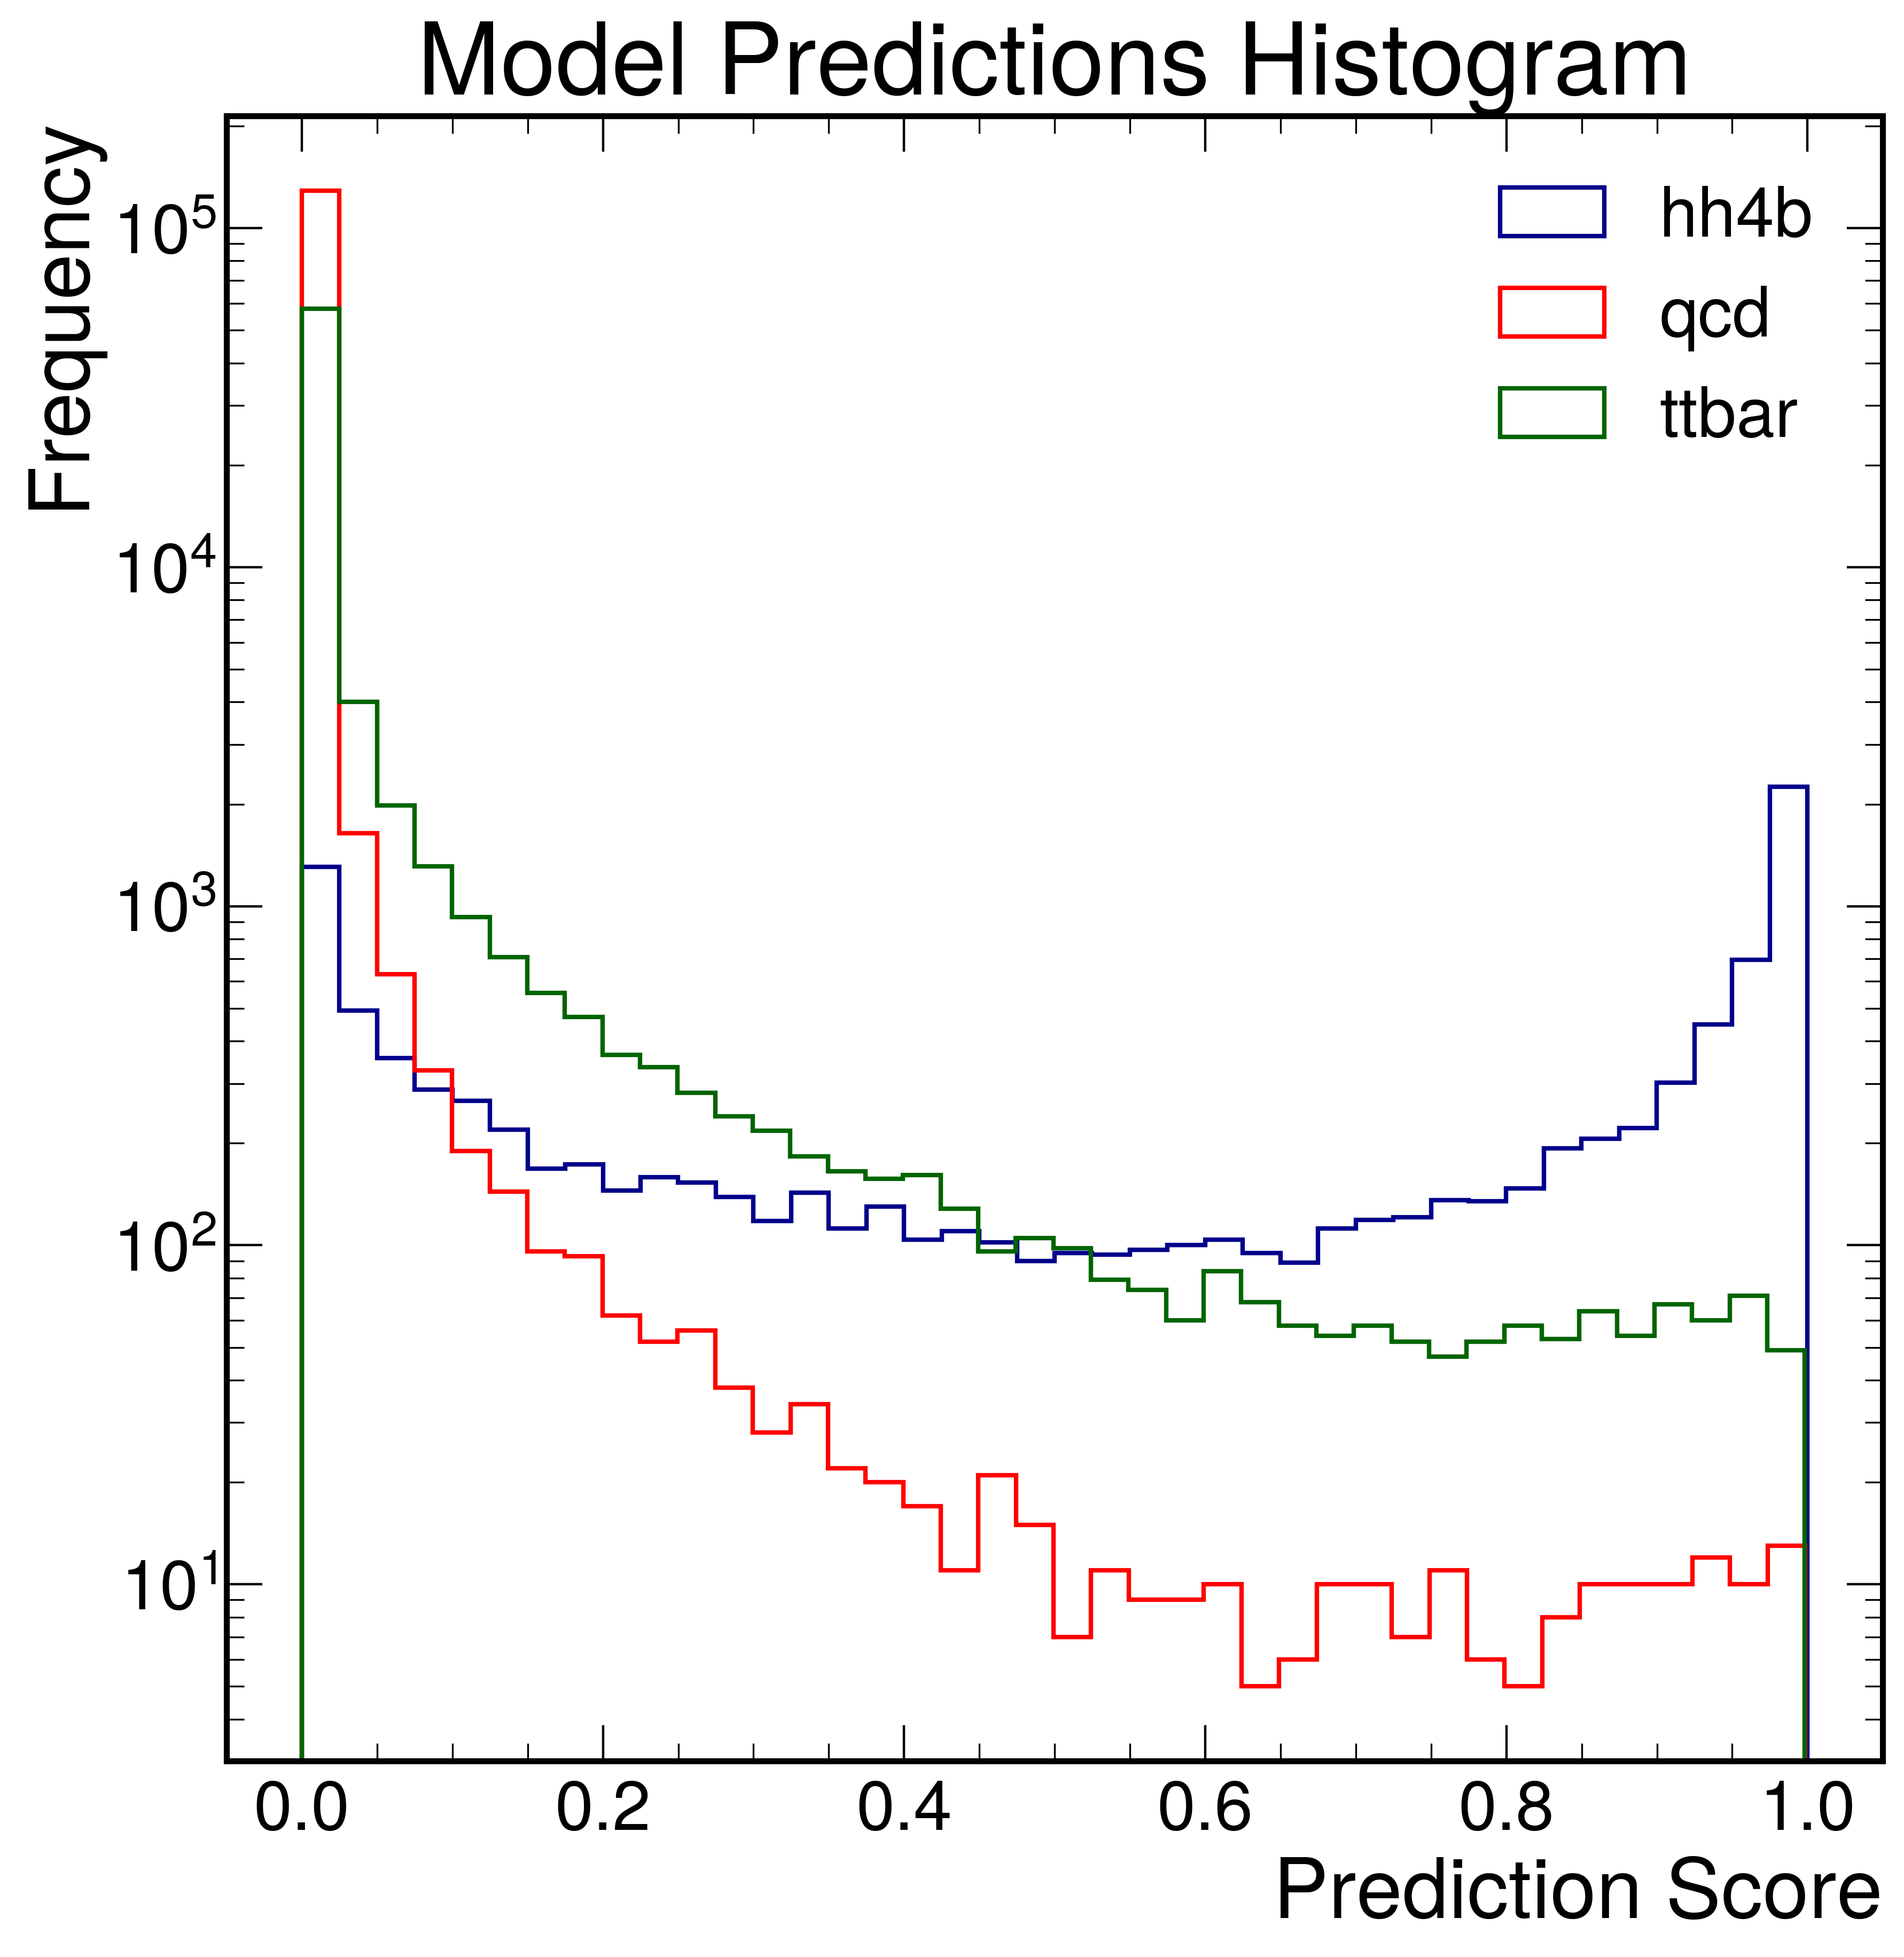

In [95]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype='step', linewidth=1.5, color='darkblue')
plt.hist(qcd_scores, bins=40, histtype='step', linewidth=1.5, color='red')
plt.hist(ttbar_scores, bins=40, histtype='step', linewidth=1.5, color='darkgreen')
plt.legend(['hh4b', 'qcd', 'ttbar'])
plt.ylabel('Frequency')
plt.xlabel('Prediction Score')
plt.title('Model Predictions Histogram')
plt.yscale('log')
plt.show()


Predict on other samples

In [102]:
bdt_vbfhh4b = events_dict_bdt["vbfhh4b"].drop(columns=variables_not_in_bdt)
bdt_vhbb = events_dict_bdt["vhbb"].drop(columns=variables_not_in_bdt)
vbfhh4b_scores = bdt_model.predict_proba(bdt_vbfhh4b)[:, 1]
vhbb_scores = bdt_model.predict_proba(bdt_vhbb)[:, 1]


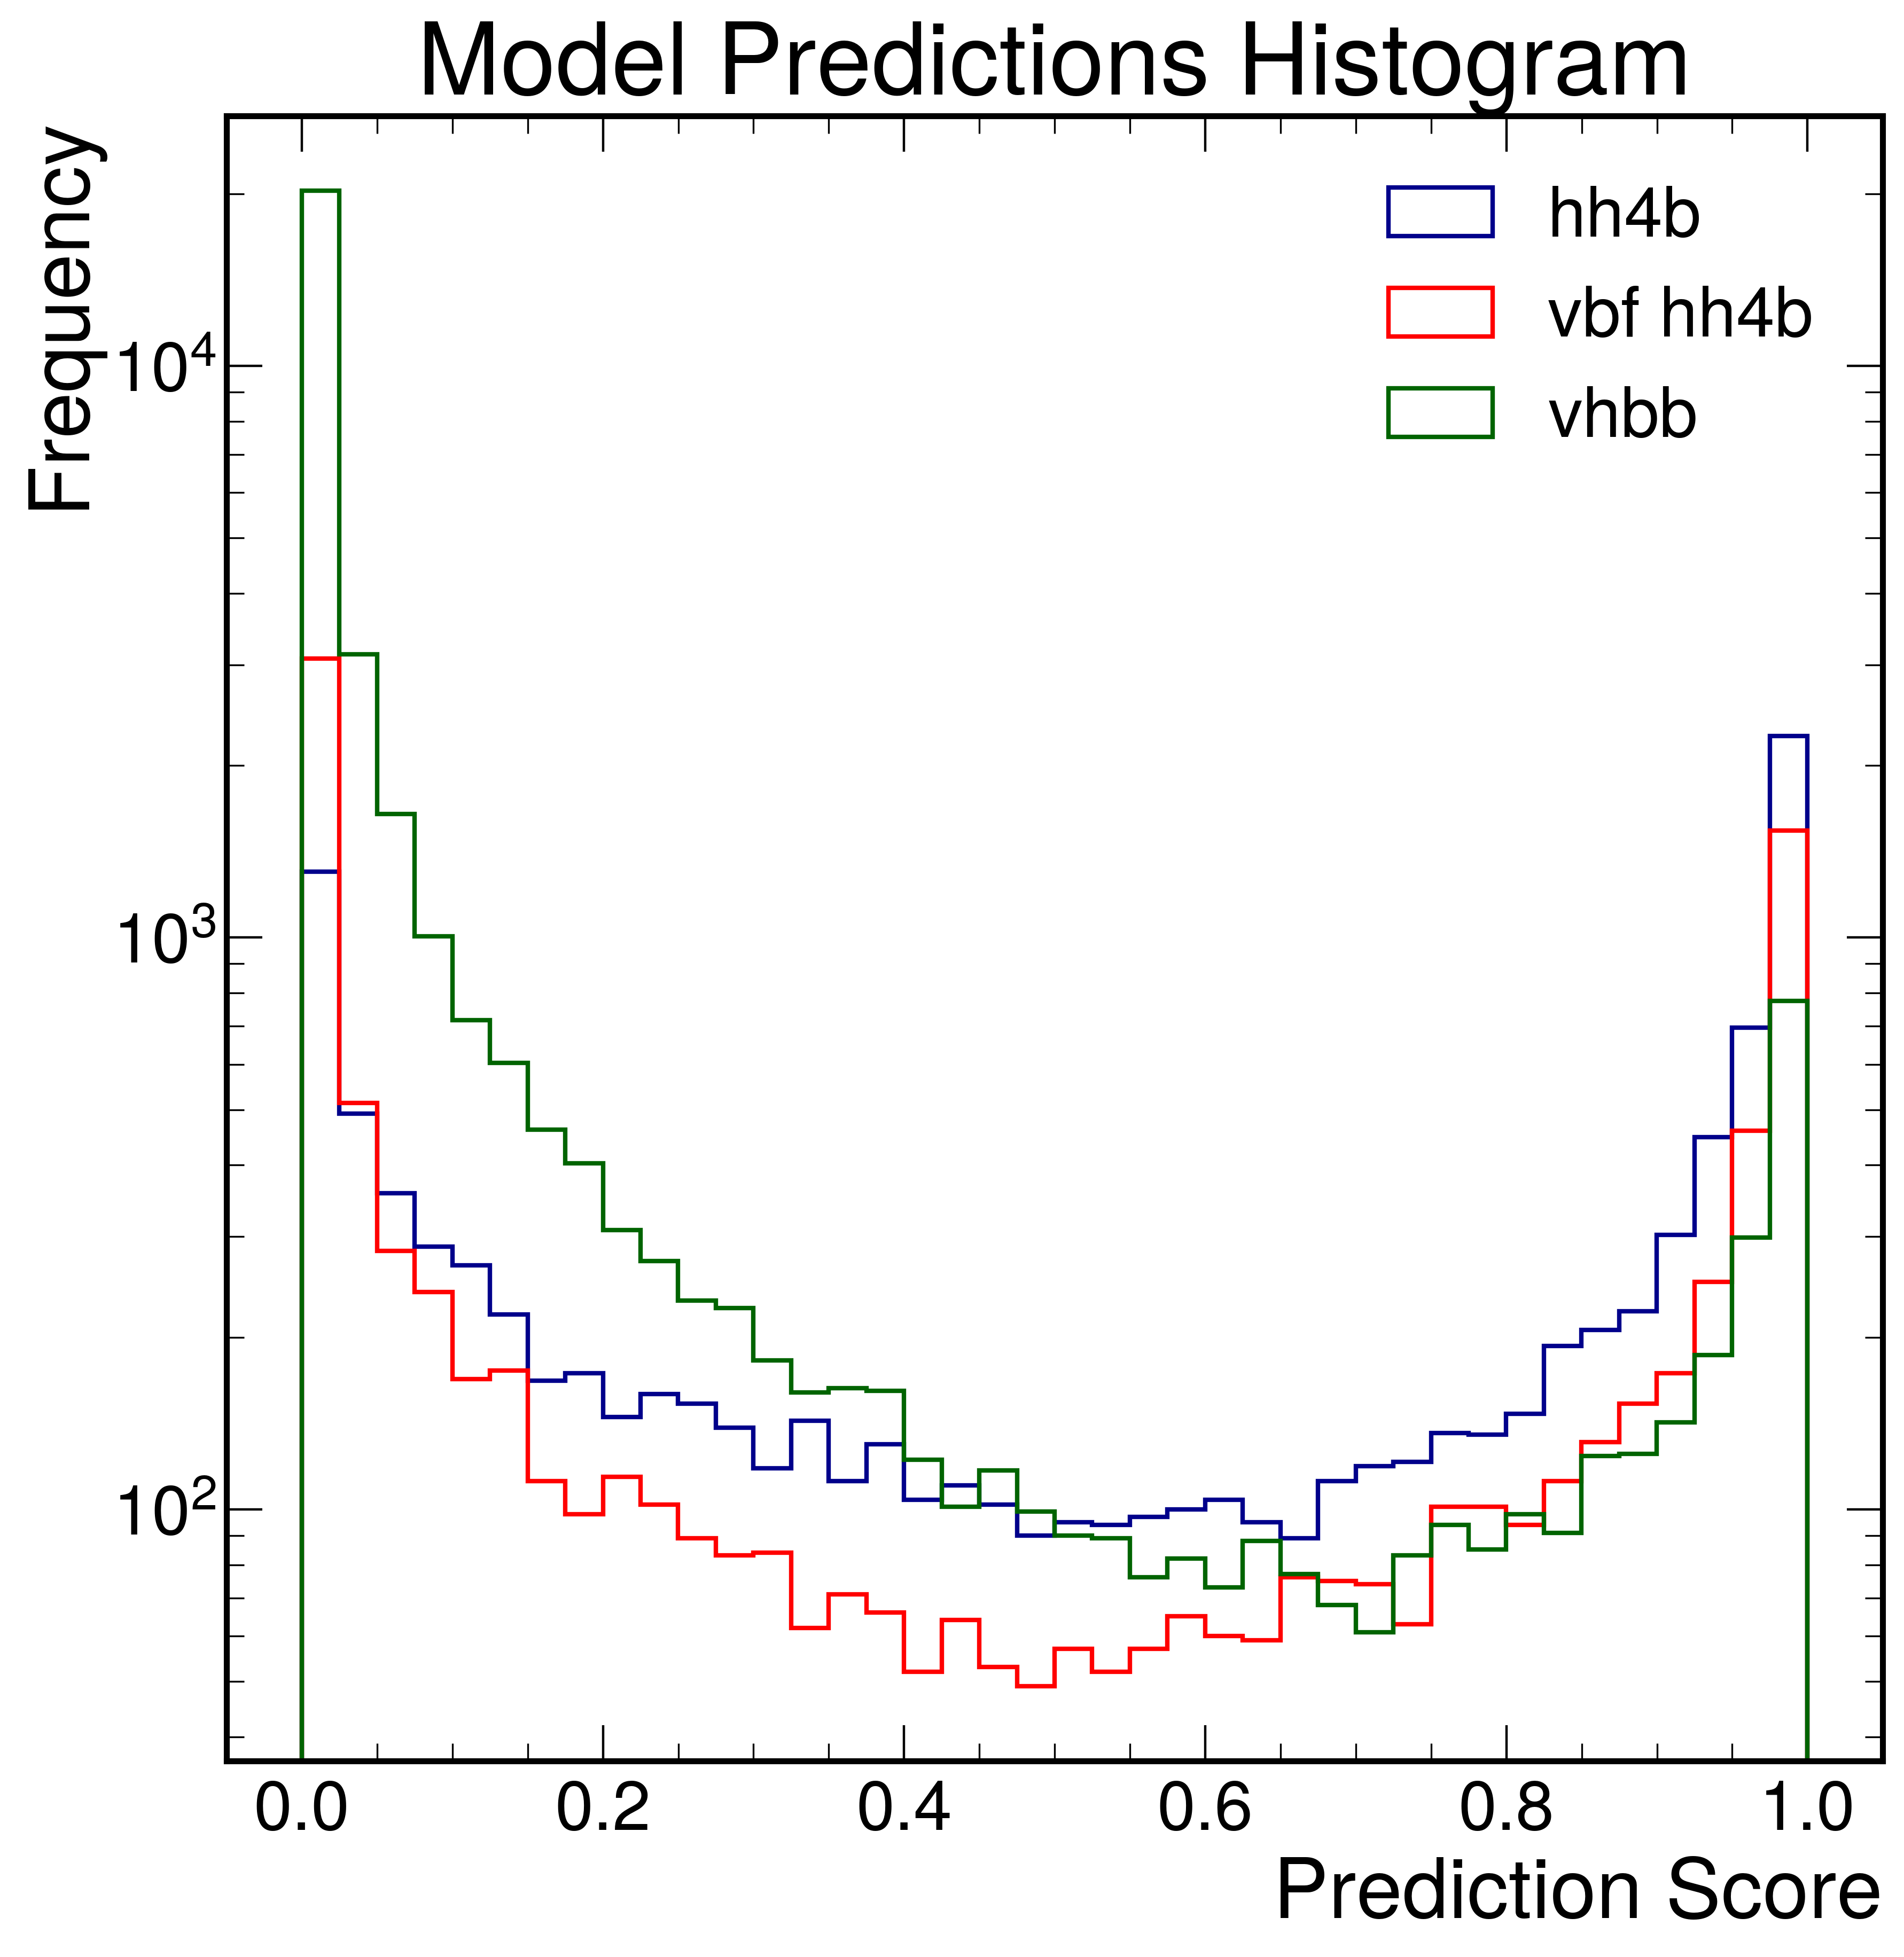

In [103]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype='step', linewidth=1.5, color='darkblue')
plt.hist(vbfhh4b_scores, bins=40, histtype='step', linewidth=1.5, color='red')
plt.hist(vhbb_scores, bins=40, histtype='step', linewidth=1.5, color='darkgreen')
plt.legend(['hh4b', 'vbf hh4b', 'vhbb'])
plt.ylabel('Frequency')
plt.xlabel('Prediction Score')
plt.title('Model Predictions Histogram')
plt.yscale('log')
plt.show()

Plot h2 mass after BDT cuts

In [105]:
bdt_qcd = events_dict_bdt["qcd"].drop(columns=variables_not_in_bdt)
bdt_hh4b = events_dict_bdt["hh4b"].drop(columns=variables_not_in_bdt)
qcd_scores = bdt_model.predict_proba(bdt_qcd)[:, 1]
hh4b_scores = bdt_model.predict_proba(bdt_hh4b)[:, 1]

scores_dict = {
    "qcd": qcd_scores,
    "hh4b": hh4b_scores,
    "vbfhh4b": vbfhh4b_scores,
    "vhbb": vhbb_scores,
}



In [118]:
cat_axis = hist.axis.StrCategory([], name="Sample", growth=True)
cut_axis = hist.axis.StrCategory([], name="Cut", growth=True)
h2_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"Higgs 2 mass [GeV]")

hist_h2 = hist.Hist(h2_mass_axis, cut_axis, cat_axis)
bdt_cuts = [0, 0.2, 0.4]

for key in ["qcd", "hh4b"]:
    scores = scores_dict[key]
    events = events_dict_bdt[key]
    h2_mass = events["H2Msd"]

    for cut in bdt_cuts:
        mask = (scores >= cut)
        hist_h2.fill(h2_mass[mask], str(cut), key)

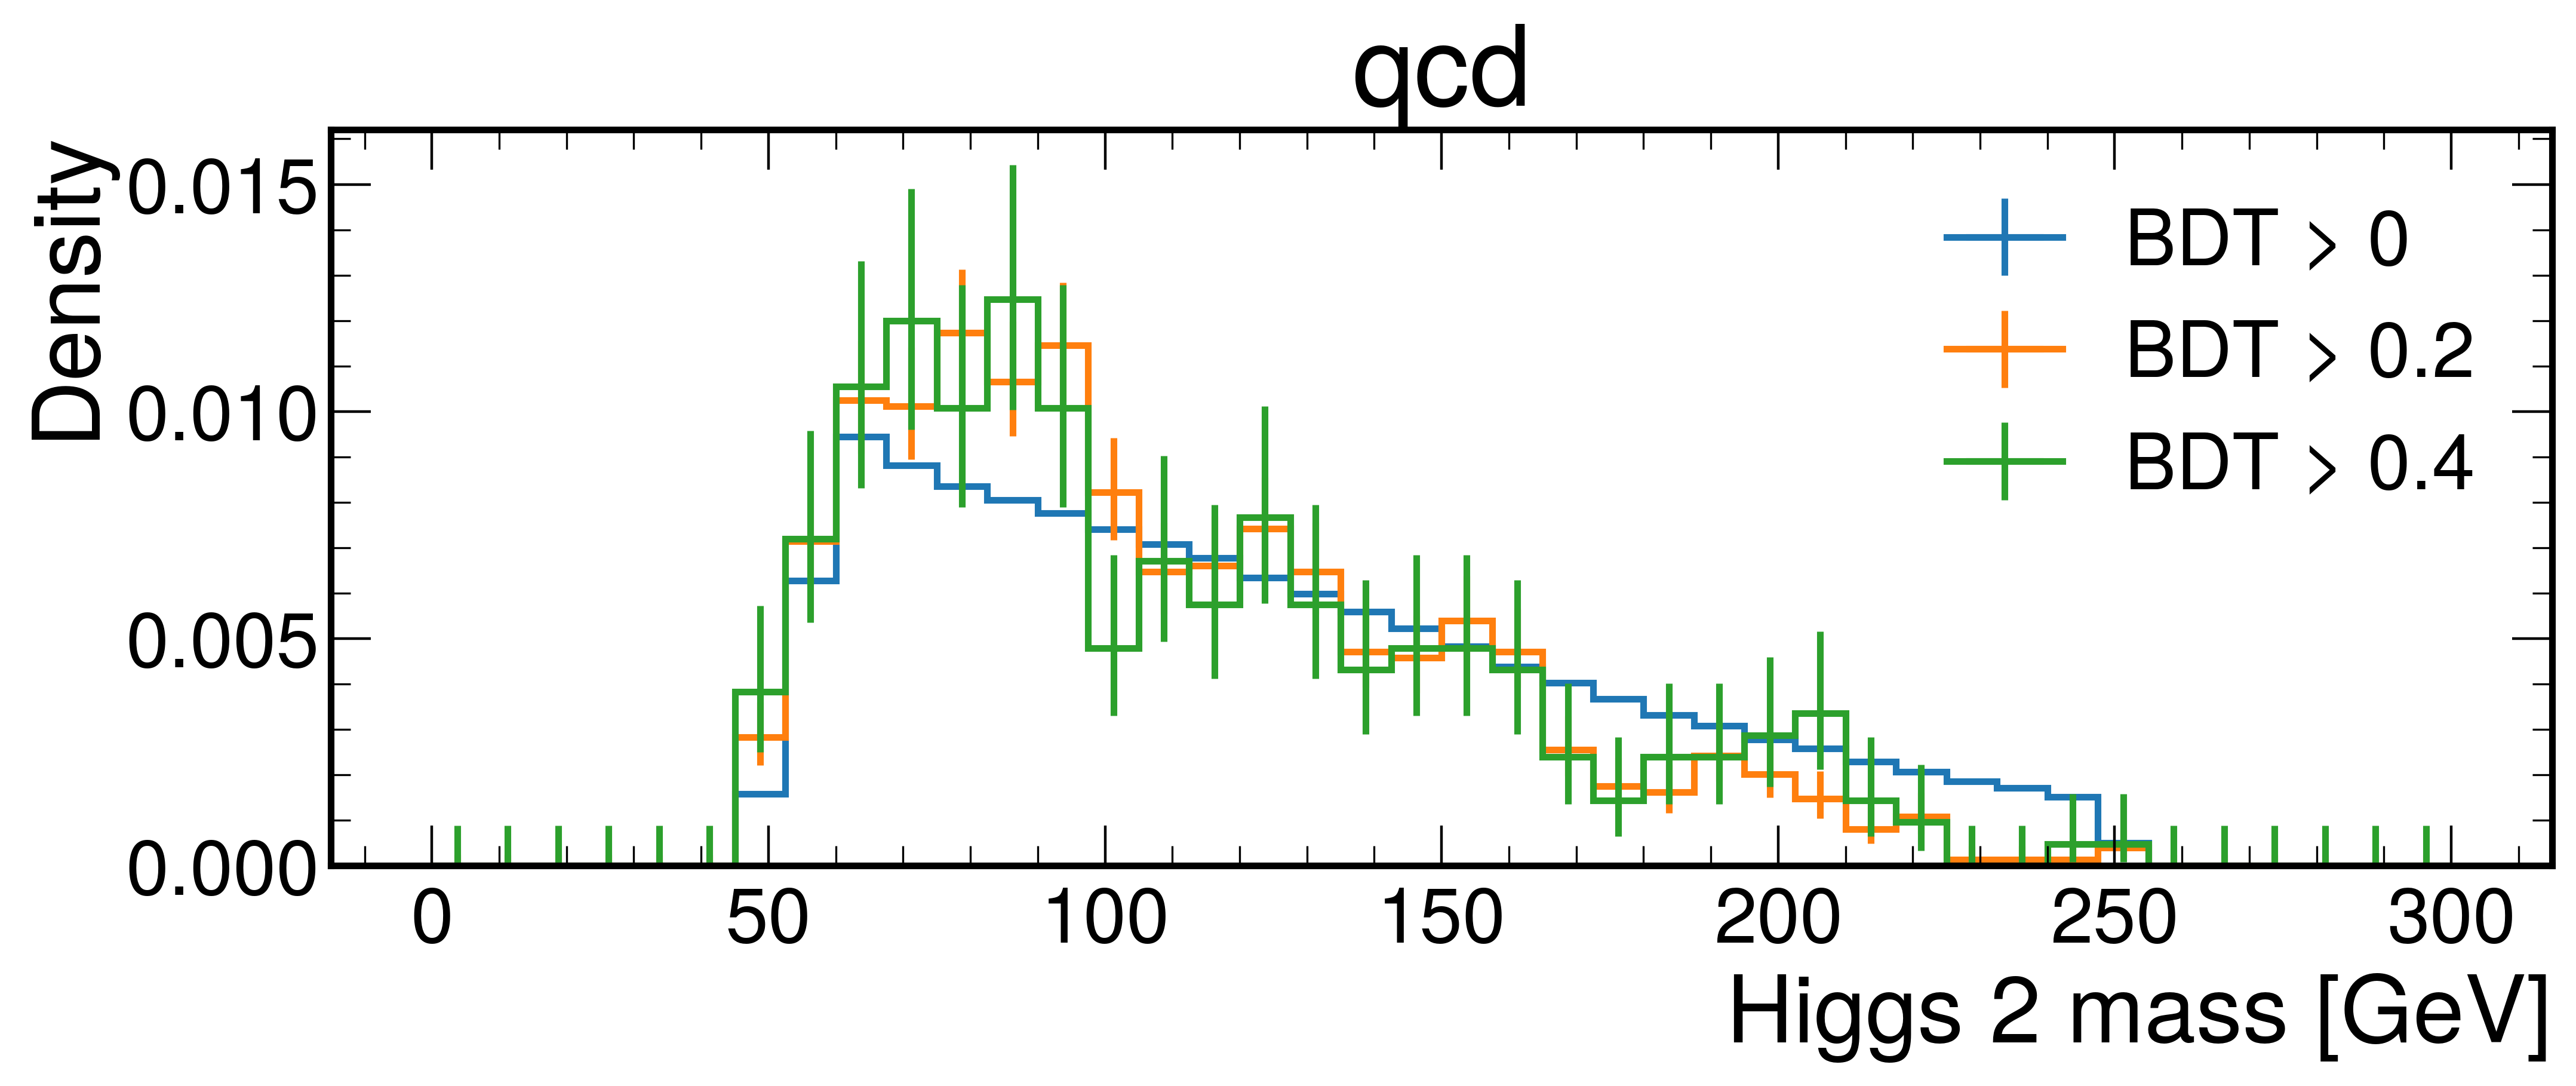

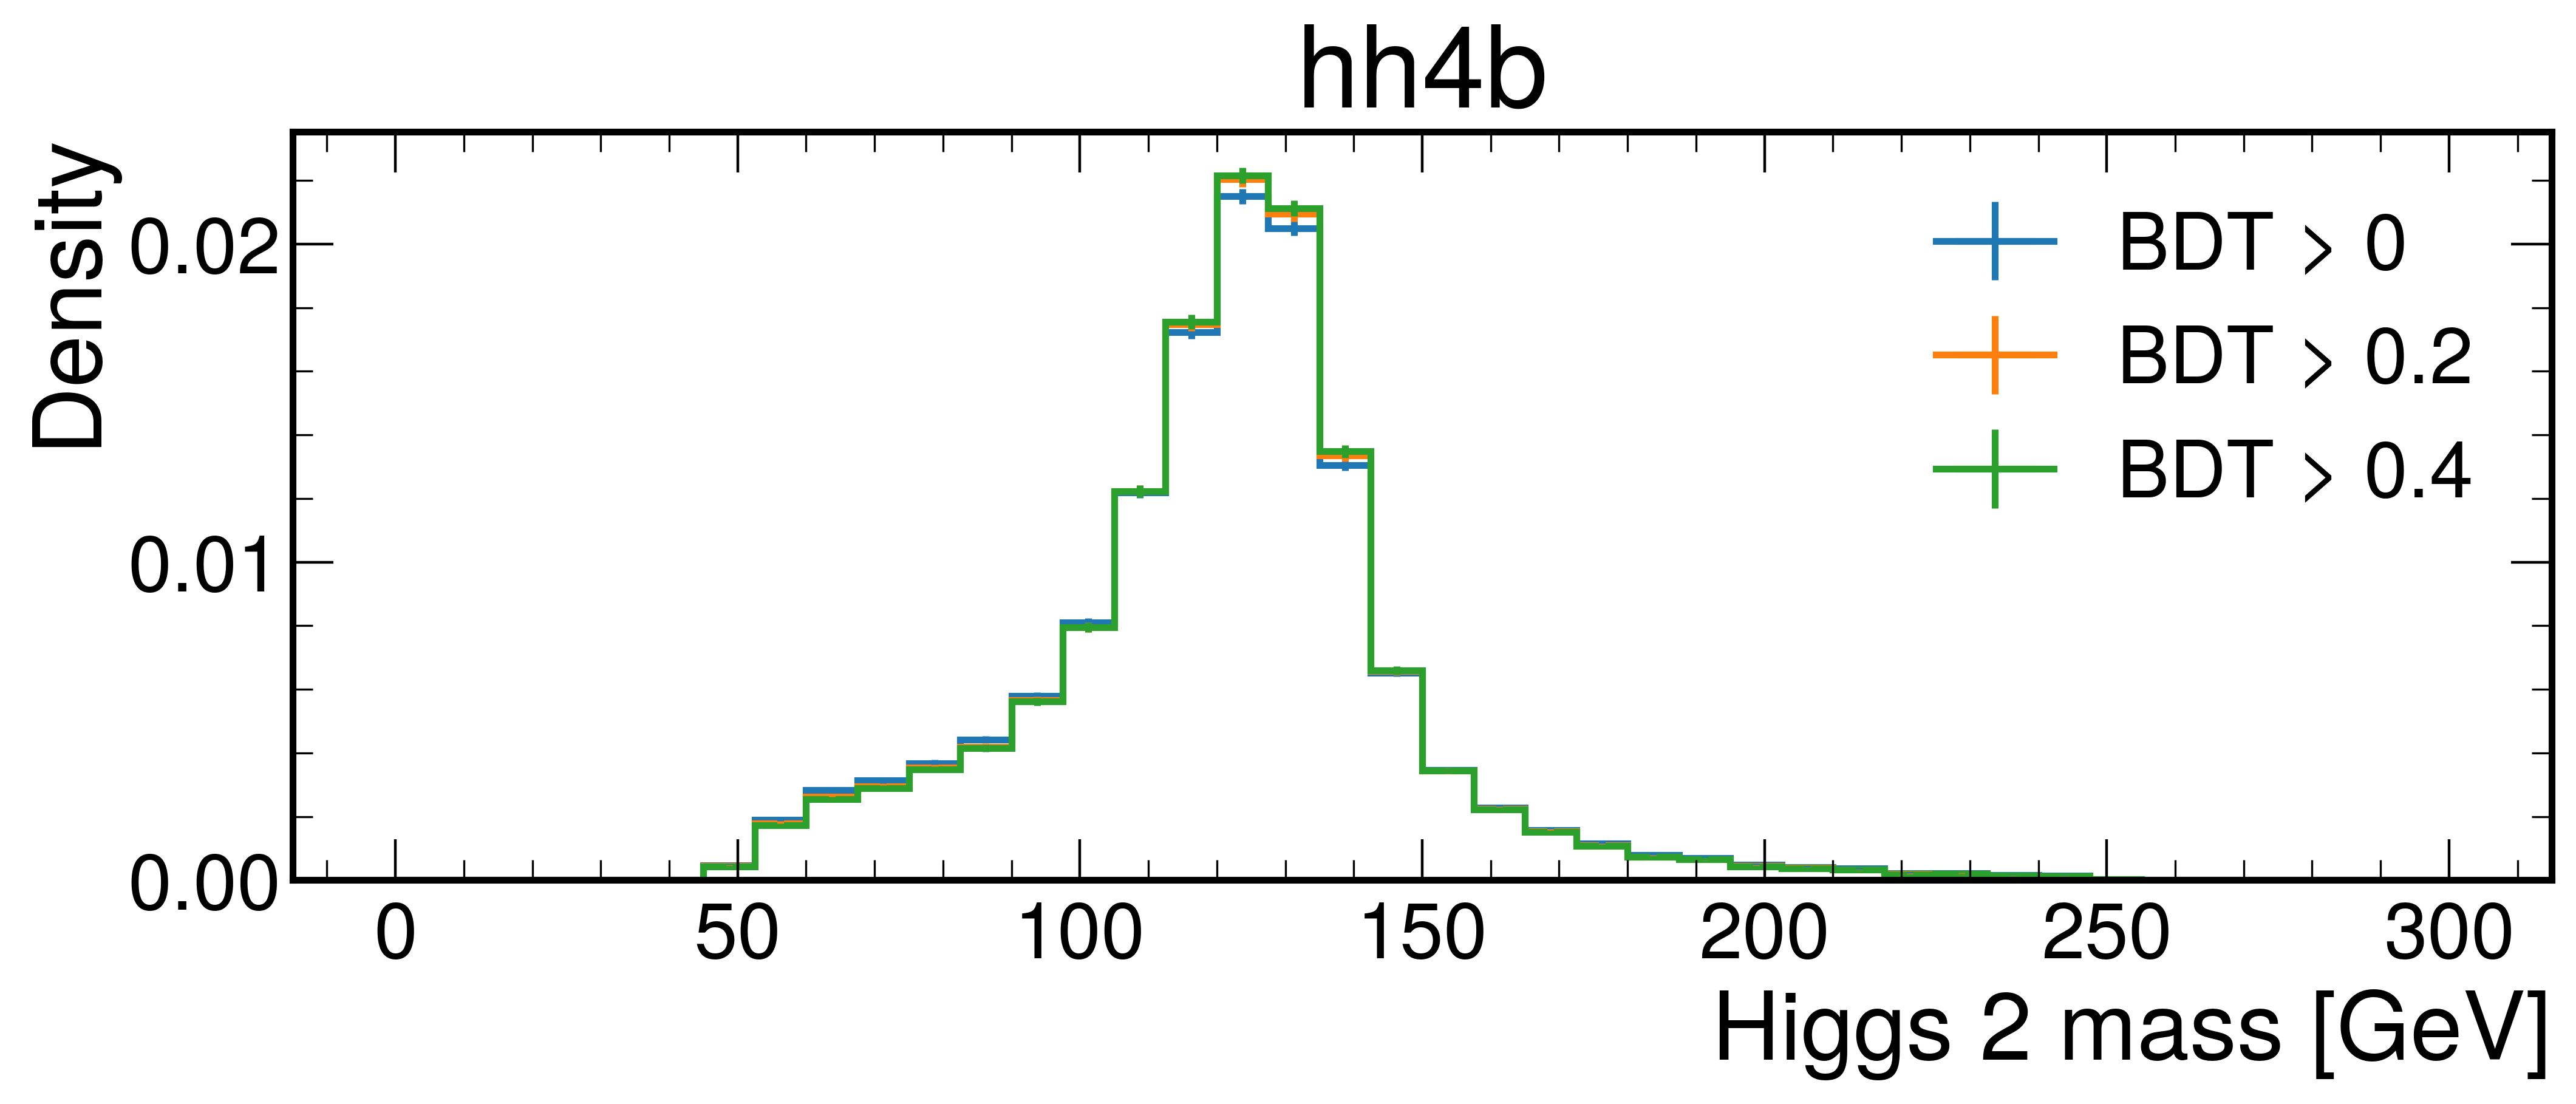

In [119]:
for key in ["qcd", "hh4b"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for cut in bdt_cuts:
        hep.histplot(
            hist_h2[{"Sample": key, "Cut": str(cut)}],
            density=True,
            lw=2,
            label=f"BDT > {cut}"
        )
    ax.legend()
    ax.set_ylabel("Density")
    ax.set_title(key)

### Compare with old BDT (trained in Run 2 data)

- The problem with this comparison is that the BDT used variables that are no longer available in Run2 data `fatJet1PNetQCDb`, `fatJet1PNetQCDbb`, `fatJet1PNetQCDOthers`

In [79]:
# from https://github.com/LPC-HH/HHLooper/blob/master/python/xgboost/append_xgboost_discriminator_to_tree_withSystematics_MC_2018.py
_model_name = (
    f"{MAIN_DIR}/../data/model_xgboost_training_weights_qcd_and_ttbar_Run2_bdt_enhanced_v8p2.pkl"
)

with open(_model_name, "rb") as pkl_file:
    model_run2 = pickle.load(pkl_file)

variables = [
    # branche name, BDT name
    ["hh_pt", "hh_pt", "$p_{T}^{HH}$ (GeV)", 40, 0, 5000],
    ["hh_eta", "hh_eta", "$\eta^{HH}$", 40, -5.0, 5.0],
    ["hh_mass", "hh_mass", "$m_{HH}$ (GeV)", 40, 0, 1500],
    ["met", "met", "$MET$ (GeV)", 60, 0, 600],
    ["fatJet1Tau3OverTau2", "fatJet1Tau3OverTau2", "fatJet1Tau3OverTau2", 50, 0.0, 1.0],
    ["fatJet2Tau3OverTau2", "fatJet2Tau3OverTau2", "fatJet2Tau3OverTau2", 50, 0.0, 1.0],
    ["fatJet1MassSD", "j1_mass_sd", "$M_{j1}$ (GeV)", 40, 0.0, 5000.0],
    ["fatJet1Pt", "j1_pt", "$p_{T}^{j1}$ (GeV)", 40, 0.0, 5000.0],
    ["fatJet1Eta", "j1_eta", "$\eta^{j1}$", 40, -2.5, 2.5],
    ["fatJet1PNetXbb", "fatJet1PNetXbb", "fatJet1PNetXbb", 40, -100, 100],
    ["fatJet1PNetQCDb", "fatJet1PNetQCDb", "fatJet1PNetQCDb", 40, -100, 100],
    ["fatJet1PNetQCDbb", "fatJet1PNetQCDbb", "fatJet1PNetQCDbb", 40, -100, 100],
    ["fatJet1PNetQCDothers", "fatJet1PNetQCDothers", "fatJet1PNetQCDothers", 40, -100, 100],
    ["fatJet2Pt", "j2_pt", "$p_{T}^{j2}$ (GeV)", 40, 0.0, 500.0],
    ["fatJet1PtOverMHH", "ptj1Omhh", "$p_{T}^{j1}/m_{HH}$", 40, 0.0, 1.0],
    ["fatJet2PtOverMHH", "ptj2Omhh", "$p_{T}^{j2}/m_{HH}$", 40, 0.0, 0.7],
    ["ptj2_over_ptj1", "ptj2Optj1", "$p_{T}^{j2}/p_{T}^{j1}$", 40, 0.5, 1.0],
]
var_names = [x[0] for x in variables]


def bdt_dataframe(key):
    events = events_dict[key]
    bb_mask = bb_masks[key]
    events_bdt = pd.DataFrame()
    events_bdt["fatJet1Pt"] = utils.get_feat(events, "bb0FatJetPt", bb_mask)
    events_bdt["fatJet1Eta"] = utils.get_feat(events, "bb0FatJetEta", bb_mask)
    events_bdt["fatJet1Phi"] = utils.get_feat(events, "bb0FatJetPhi", bb_mask)
    events_bdt["fatJet1Mass"] = utils.get_feat(events, "bb0FatJetMsd", bb_mask)

    events_bdt["fatJet2Pt"] = utils.get_feat(events, "bb1FatJetPt", bb_mask)
    events_bdt["fatJet2Eta"] = utils.get_feat(events, "bb1FatJetEta", bb_mask)
    events_bdt["fatJet2Phi"] = utils.get_feat(events, "bb1FatJetPhi", bb_mask)
    events_bdt["fatJet2Mass"] = utils.get_feat(events, "bb1FatJetMsd", bb_mask)

    events_bdt["fatJet1PNetXbb"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask)
    # these variables do not exist in Run 3 ntuples
    events_bdt["fatJet1PNetQCDb"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask) # RUN3
    events_bdt["fatJet1PNetQCDbb"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask)  # RUN3
    events_bdt["fatJet1PNetQCDothers"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask)  # RUN3
    # events_bdt["fatJet1PNetQCDb"] = utils.get_feat(events, "bb0FatJetPNetQCDb", bb_mask)
    # events_bdt["fatJet1PNetQCDbb"] = utils.get_feat(events, "bb0FatJetPNetQCDbb", bb_mask)
    # events_bdt["fatJet1PNetQCDothers"] = utils.get_feat(events, "bb0FatJetPNetQCDothers", bb_mask)

    events_bdt["fatJet1MassSD"] = utils.get_feat(events, "bb0FatJetMsd", bb_mask)

    h1 = utils.make_vector(events, "bb0FatJet", bb_mask=bb_mask, mstring="Msd")
    h2 = utils.make_vector(events, "bb1FatJet", bb_mask=bb_mask, mstring="Msd")
    hh = h1 + h2
    events_bdt["hh_pt"] = hh.pt
    events_bdt["hh_eta"] = hh.eta
    events_bdt["hh_mass"] = hh.mass
    events_bdt["met"] = utils.get_feat(events, "MET_pt")
    events_bdt["fatJet1Tau3OverTau2"] = utils.get_feat(events, "bb0FatJetTau3OverTau2", bb_mask)
    events_bdt["fatJet2Tau3OverTau2"] = utils.get_feat(events, "bb1FatJetTau3OverTau2", bb_mask)
    events_bdt["fatJet1PtOverMHH"] = events_bdt["fatJet1Pt"] / (hh.mass)
    events_bdt["fatJet2PtOverMHH"] = events_bdt["fatJet2Pt"] / (hh.mass)
    events_bdt["ptj2_over_ptj1"] = events_bdt["fatJet2Pt"] / events_bdt["fatJet1Pt"]

    events_bdt = events_bdt[var_names]
    # getting a numpy array from two pandas data frames
    x_test = events_bdt.values
    # creating numpy array for target variables
    y_test = np.zeros(len(events_bdt))
    # predict
    y_pred = model_run2.predict_proba(x_test)[:, 1]

    events_bdt["bdt_prediction"] = y_pred

    events_bdt["fatJet1PNetMass"] = utils.get_feat(events, "bb0FatJetPNetMass", bb_mask)
    events_bdt["fatJet2PNetMass"] = utils.get_feat(events, "bb1FatJetPNetMass", bb_mask)
    events_bdt["weight"] = utils.get_feat(events, "weight")
    events_bdt["fatJet2PNetXbb"] = utils.get_feat(events, "bb1FatJetPNetXbb", bb_mask)

    return events_bdt

# predict run2 bdt
events_bdt_run2_dict = {}
for key in ["hh4b", "qcd", "ttbar", "vhbb", "vbfhh4b"]:
    print(key)
    events_bdt_run2_dict[key] = bdt_dataframe(key)

hh4b
qcd
ttbar
vhbb
vbfhh4b


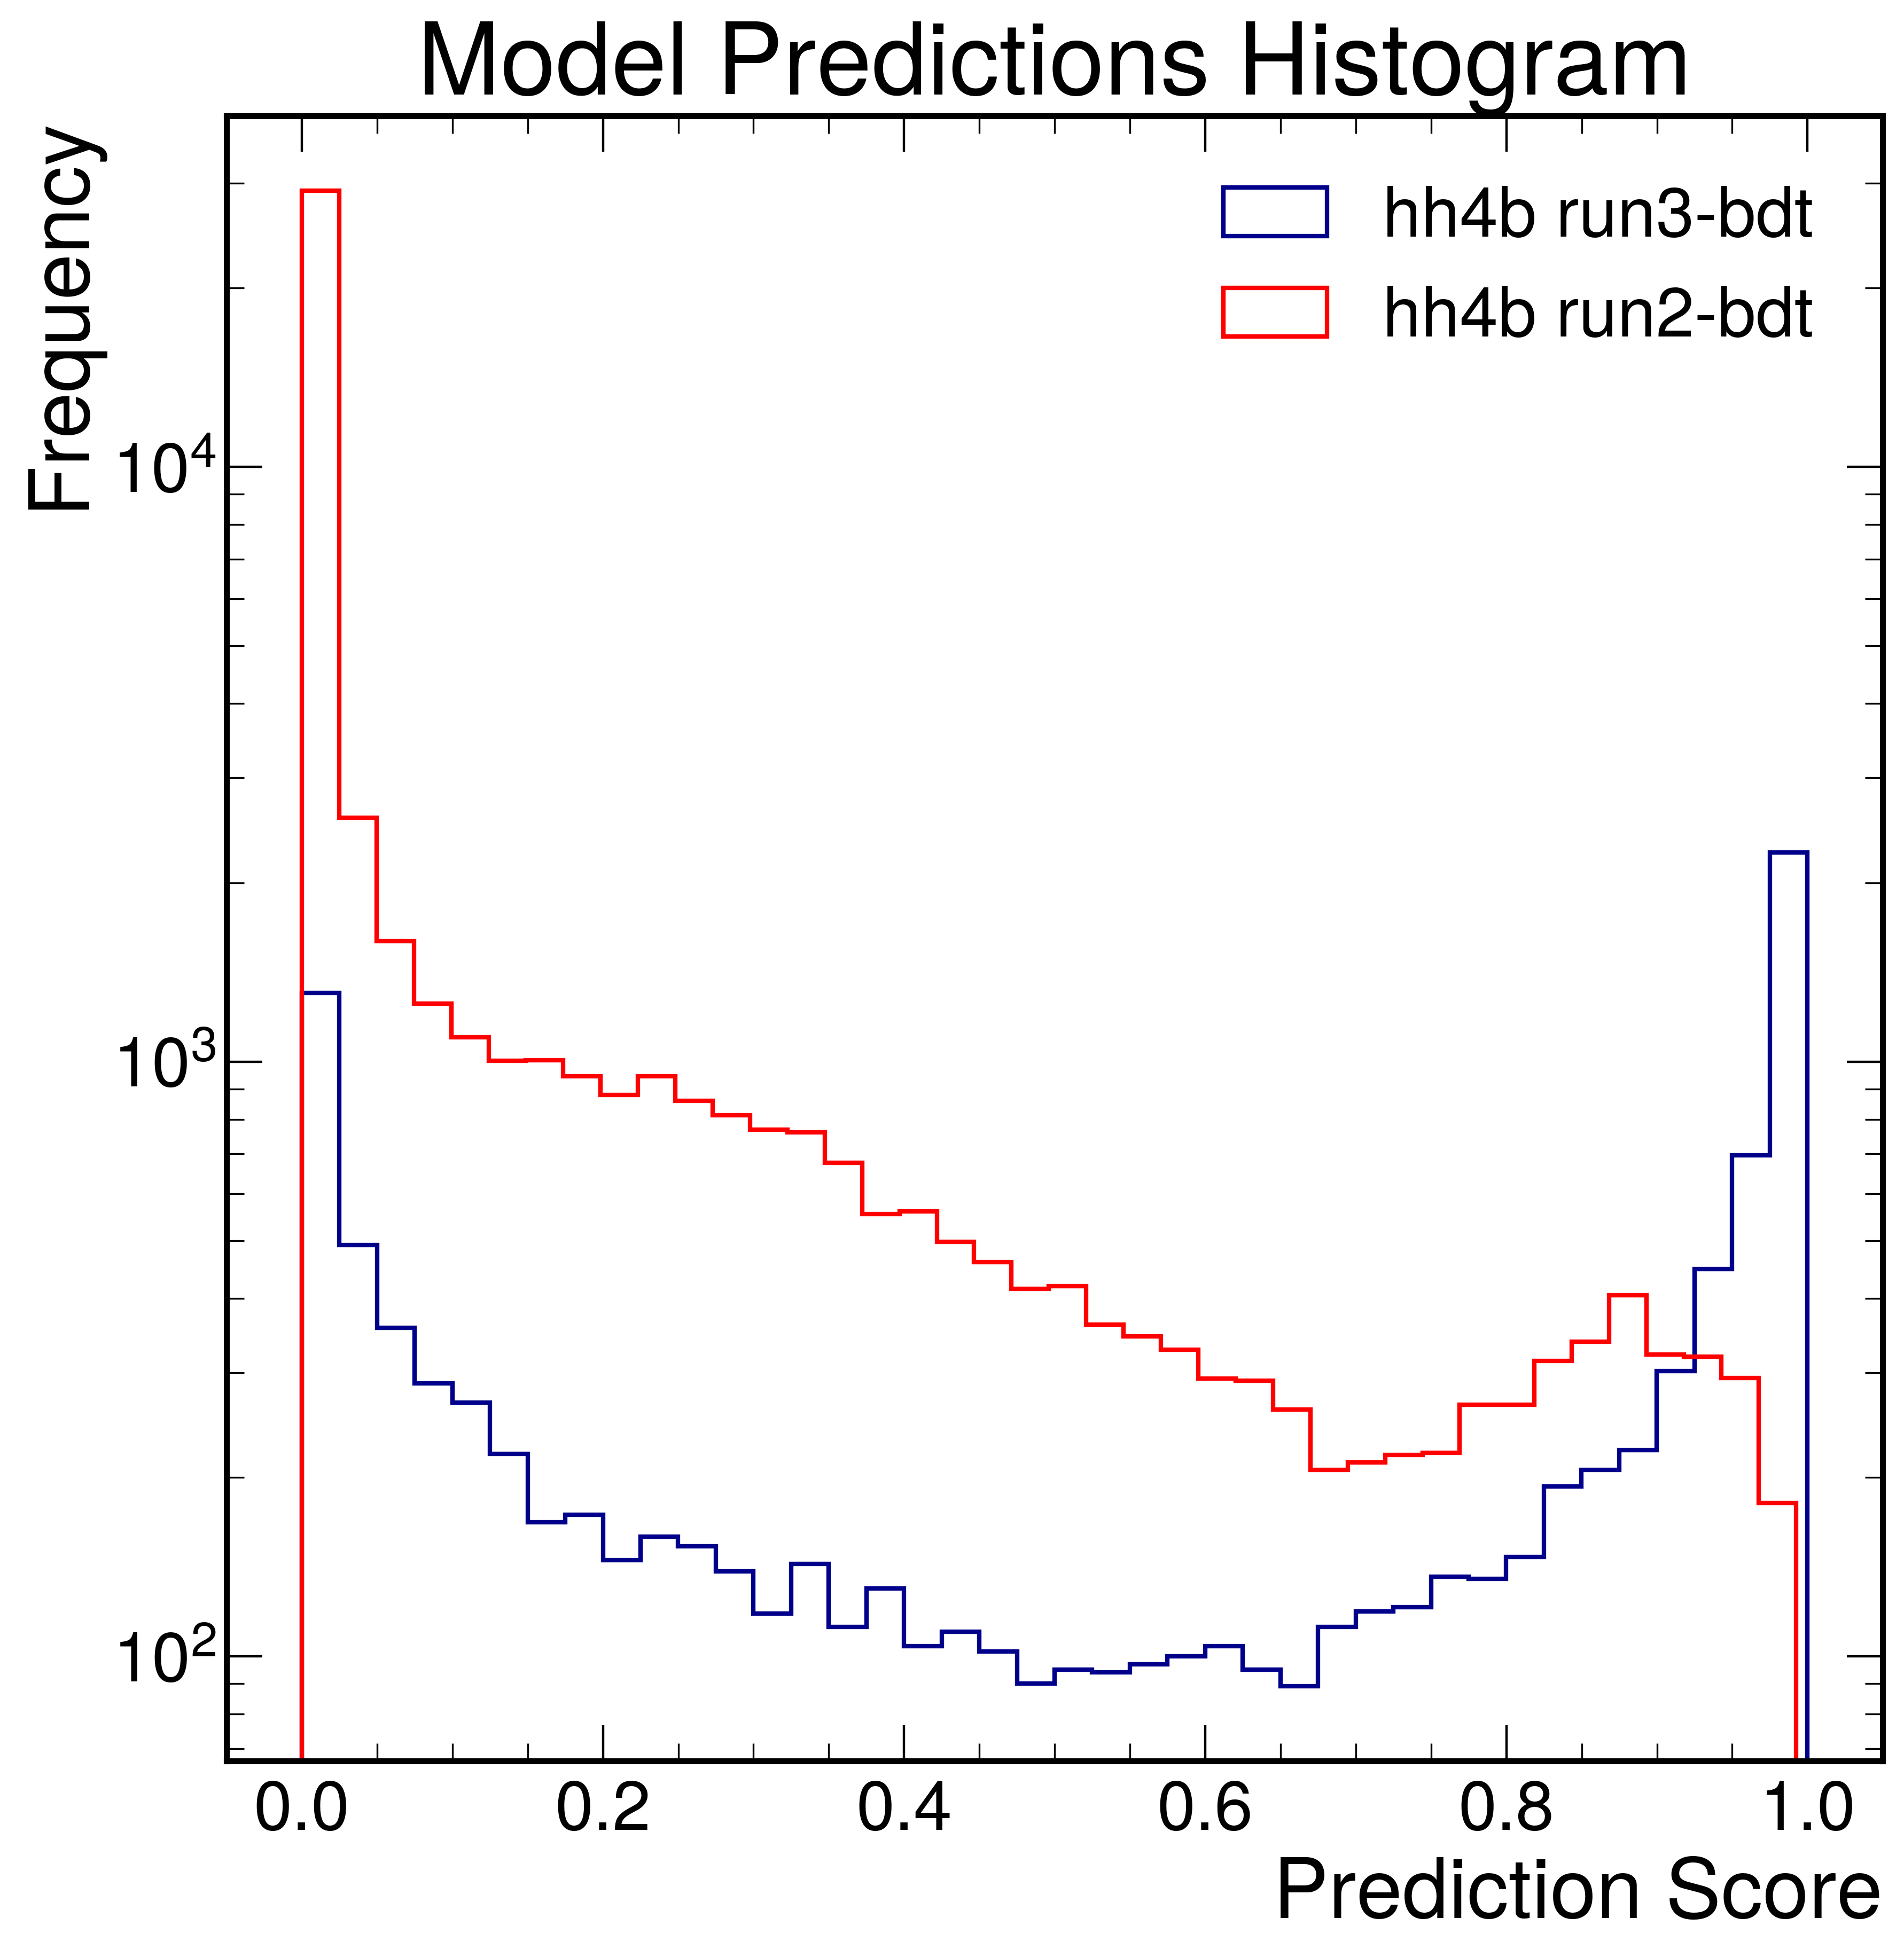

In [80]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype='step', linewidth=1.5, color='darkblue')
plt.hist(events_bdt_run2_dict["hh4b"]["bdt_prediction"], bins=40, histtype='step', linewidth=1.5, color='red')
plt.legend(['hh4b run3-bdt', 'hh4b run2-bdt'])
plt.ylabel('Frequency')
plt.xlabel('Prediction Score')
plt.title('Model Predictions Histogram')
plt.yscale('log')
plt.show()

## BDT tasks

### Different variations
- Consider event weight in training?
- Other variables to include?